# Time-Series Analysis
## a similarity analysis between categorical time series


In [30]:
import pandas as pd 
import psycopg2 as pg
import utils.settings_utils as settings
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Get the data

In [31]:
conn = pg.connect(database=settings.get_database(), user=settings.get_user(), password=settings.get_pasword())

In [32]:
def get_data_for_datasetid(datasetid, conn, interval, time='0001-01-01 00:00:00'):
    df = pd.read_sql_query(f"SELECT time AS date, open, high, low, close, volume \
                     FROM stock WHERE identifier = {datasetid} AND time > '{time}' \
                     ORDER BY time ASC;", conn)
    df.set_index(pd.DatetimeIndex(df['date']), inplace=True)
    return resample_data_to_interval(interval, df)

In [33]:
def resample_data_to_interval(interval, df):
    df_d = df.resample(interval).agg(
            {'open': 'first',
            'high': 'max', 
            'low': 'min', 
            'close': 'last', 
            'volume': 'sum'}).dropna()
    df_d.reset_index(inplace=True)
    # df_d = df_d[["date","close"]]

#     df_d["date"] = pd.to_datetime(df_d['date'])
    return df_d

In [34]:
def get_indentifier_for_sub_category(sub_category, conn):
    indentifiers= pd.read_sql_query(f"SELECT identifier, description FROM dataset where secondarycategory = '{sub_category}'", conn)
    indentifiers_list = indentifiers["identifier"].tolist()
    indentifiers_description = indentifiers["description"].tolist()
    return indentifiers_list, indentifiers_description

In [41]:
def get_dataframes(conn, indentifiers):
    df_arr = []
    for i in indentifiers:
        df_arr.append(get_data_for_datasetid(i, conn, 'D', time='2019-01-01 00:00:00'))
        #  normalize values to 0-1 
        df_arr[-1]["close"] = df_arr[-1]["close"] / df_arr[-1]["close"].max()
        # normalized_df=(df-df.mean())/df.std()
        # normalized_df= (df_arr[-1]['close'] - df_arr[-1]['close'].mean())/df_arr[-1]['close'].std() 
    # return normalized_df
    return df_arr

indentifiers, description = get_indentifier_for_sub_category("bank", conn)
df_lst = get_dataframes(conn, indentifiers)
df_lst[-1].tail()
# print(len(df_lst))
# df_lst
# df = get_data_for_datasetid(15611, conn, 'H', time='2000-01-01 00:00:00')


date   open   high    low     close    volume
497 2022-03-03  3.500  3.500  3.300  0.846344  396775.0
498 2022-03-04  3.435  3.435  3.285  0.820322  268226.0
499 2022-03-07  3.305  3.320  3.090  0.795539  847321.0
500 2022-03-08  3.205  3.300  3.205  0.806691  250260.0
501 2022-03-09  3.295  3.380  3.250  0.836431  204992.0

In [42]:
def get_subcategories(conn):
    sub_categories = pd.read_sql_query("SELECT DISTINCT secondarycategory FROM dataset", conn)
    return sub_categories["secondarycategory"].tolist()

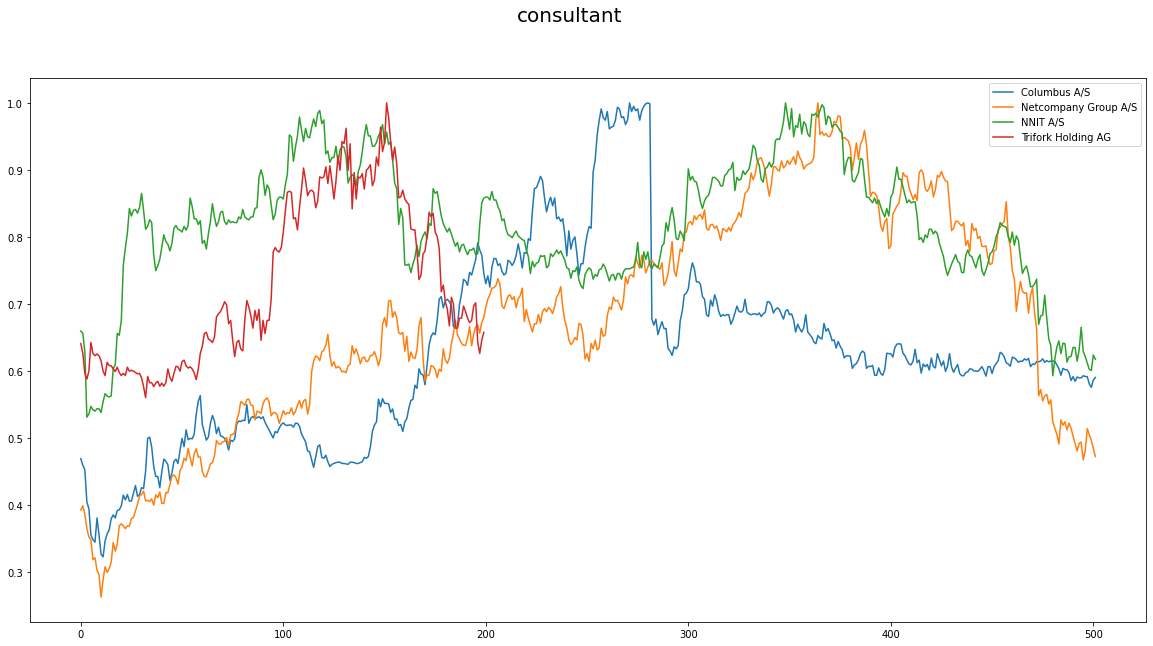

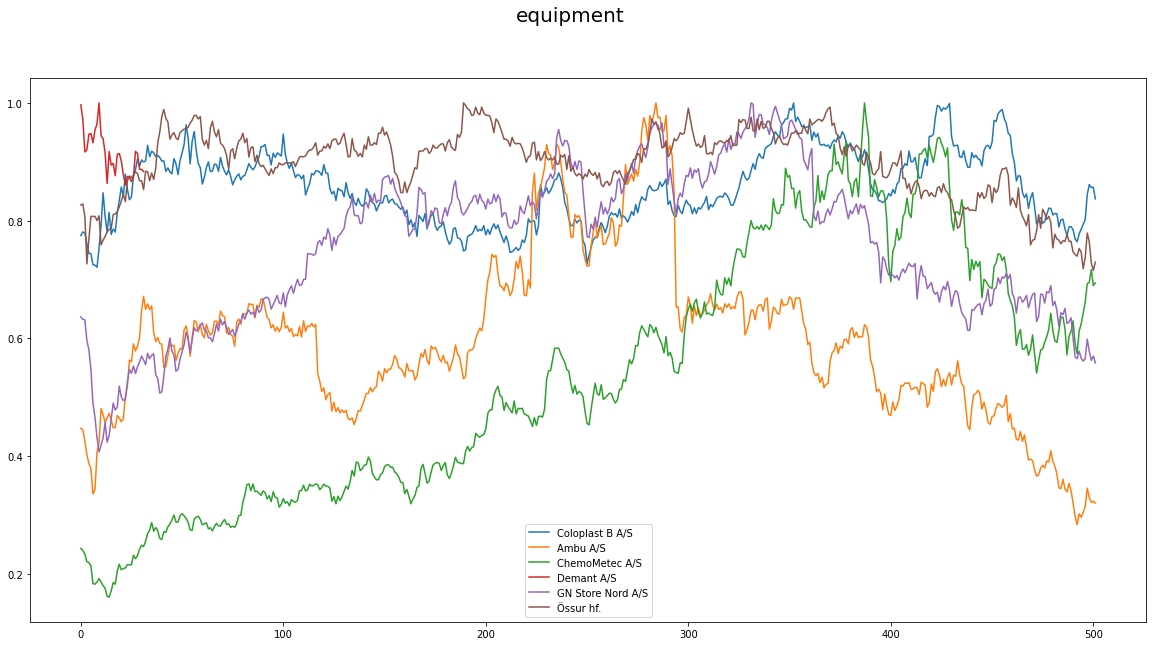

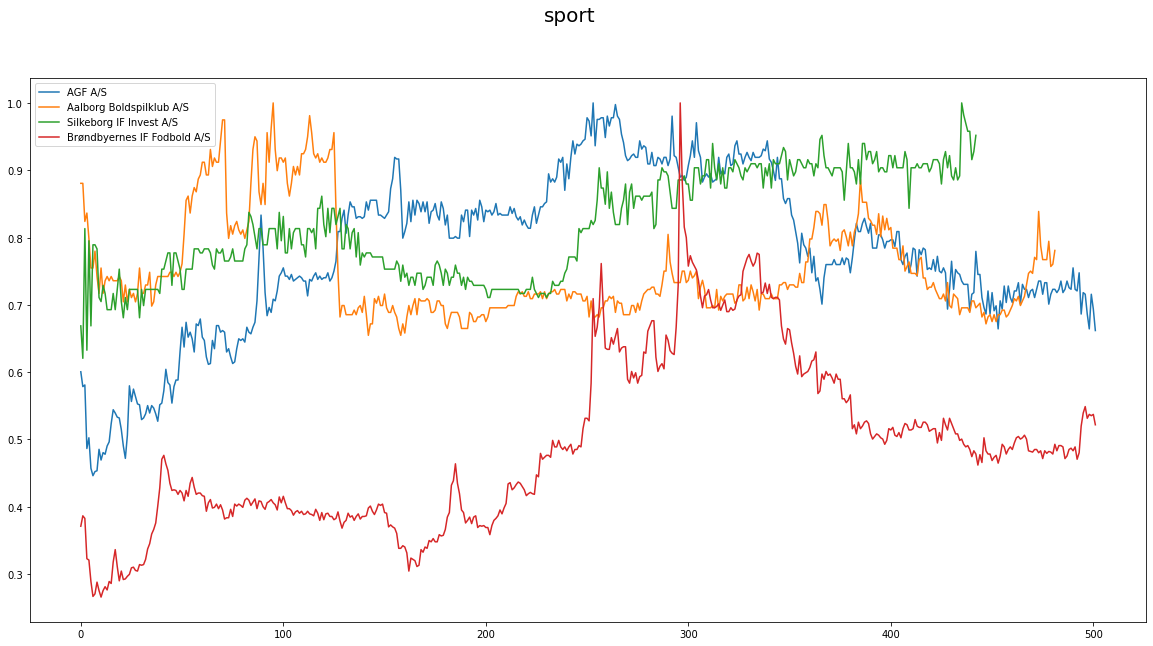

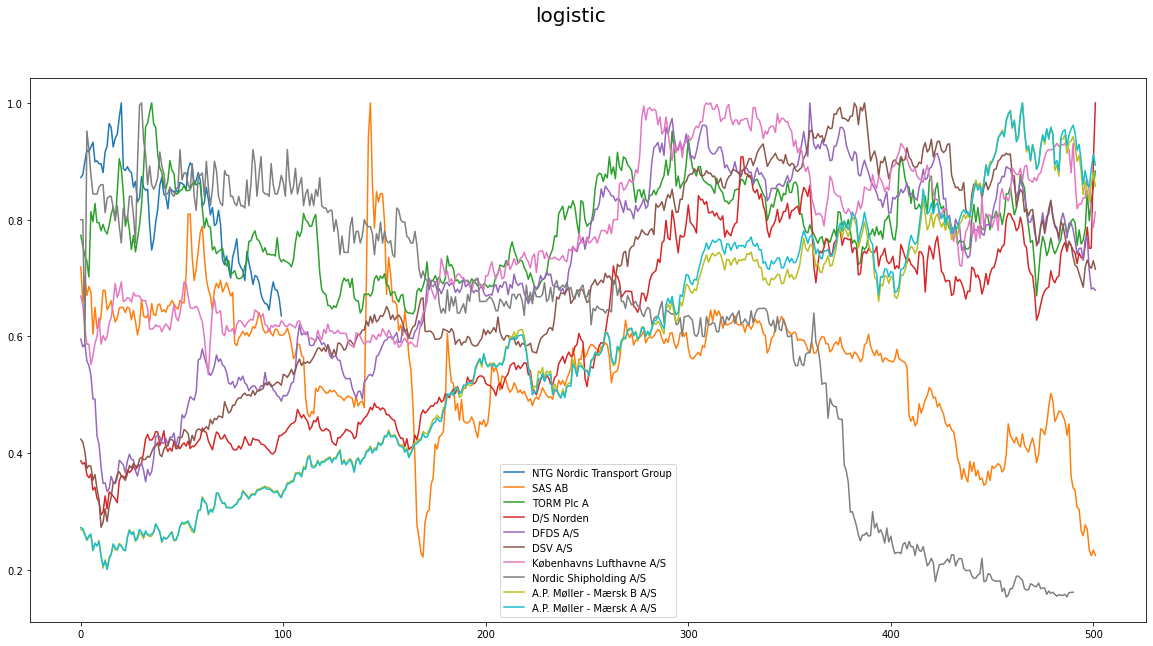

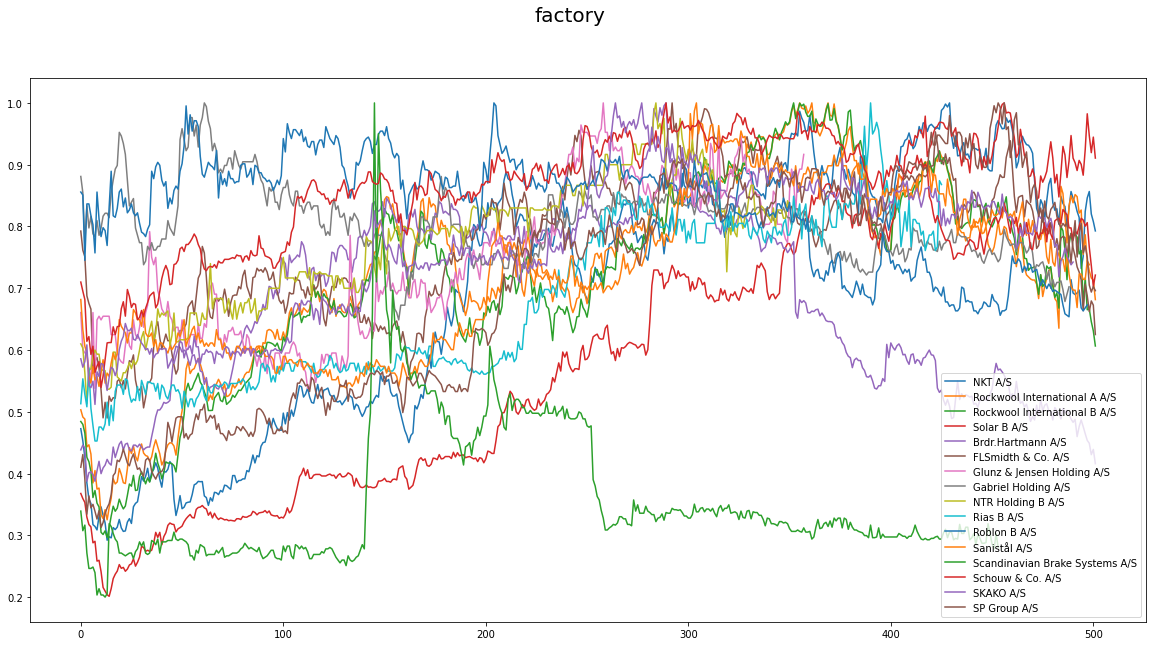

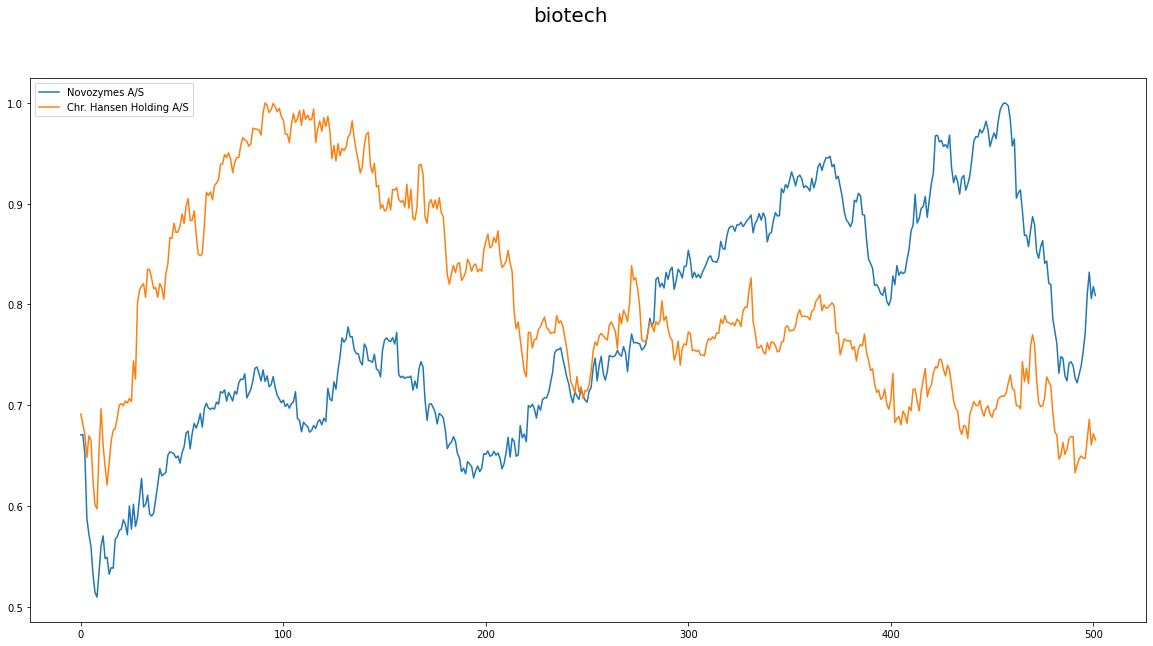

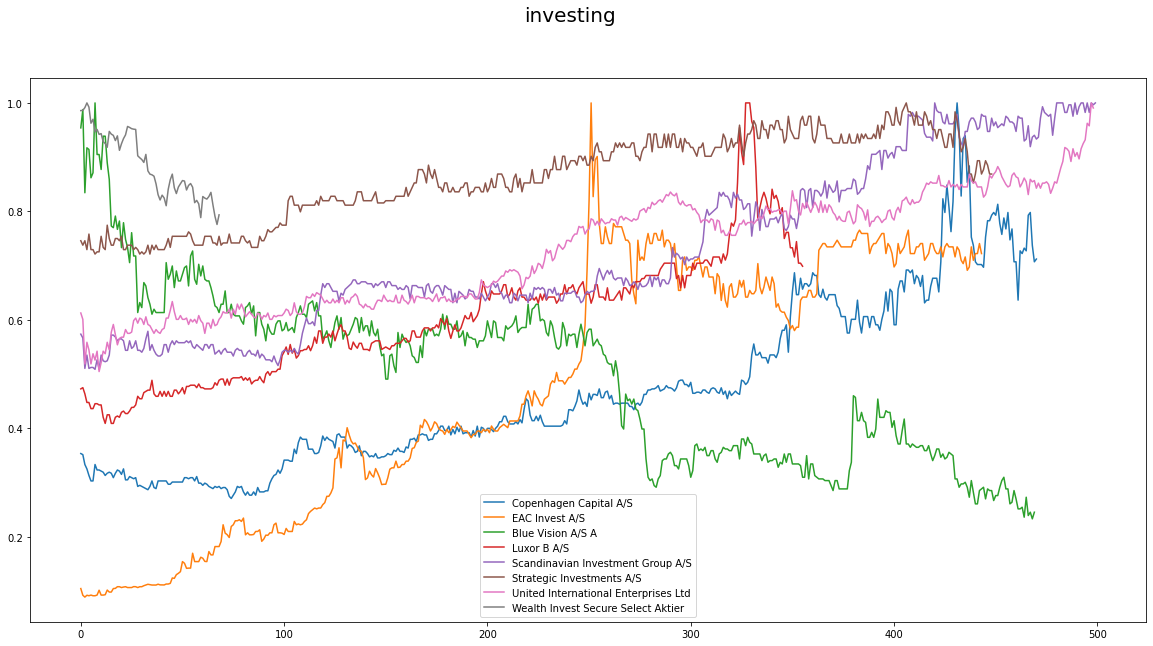

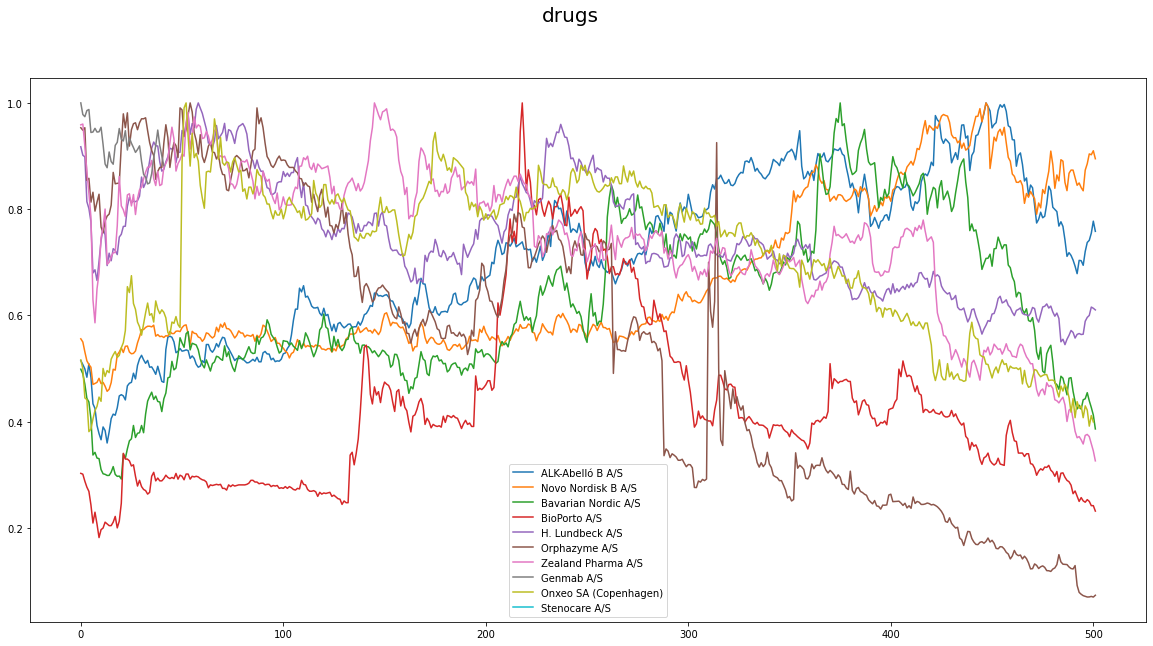

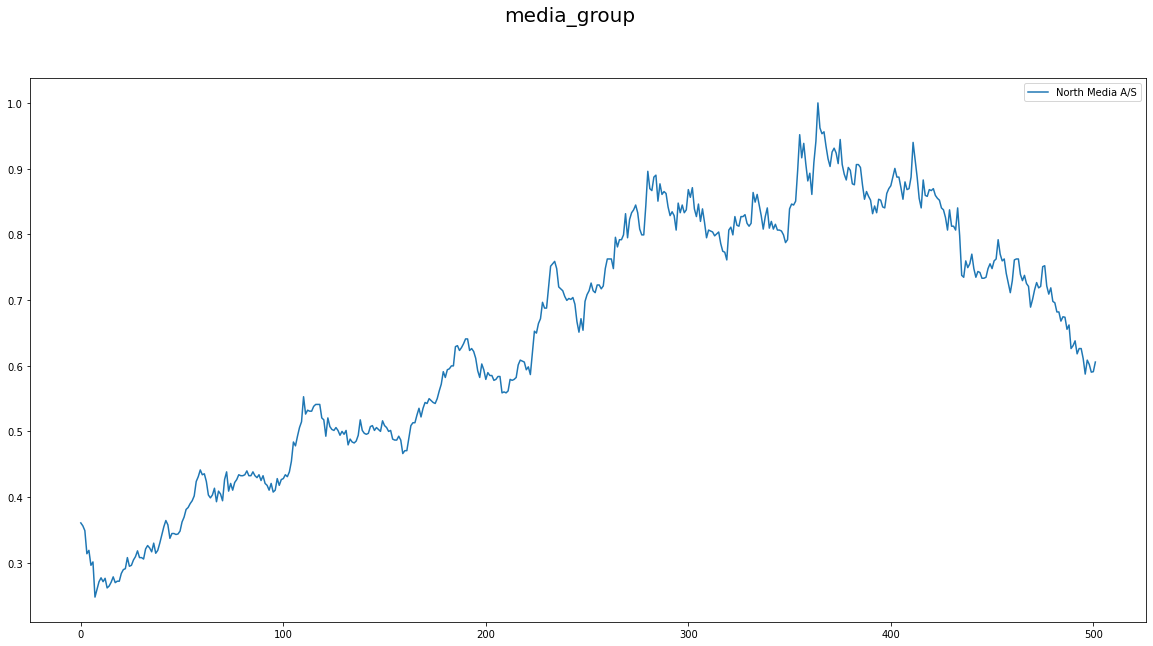

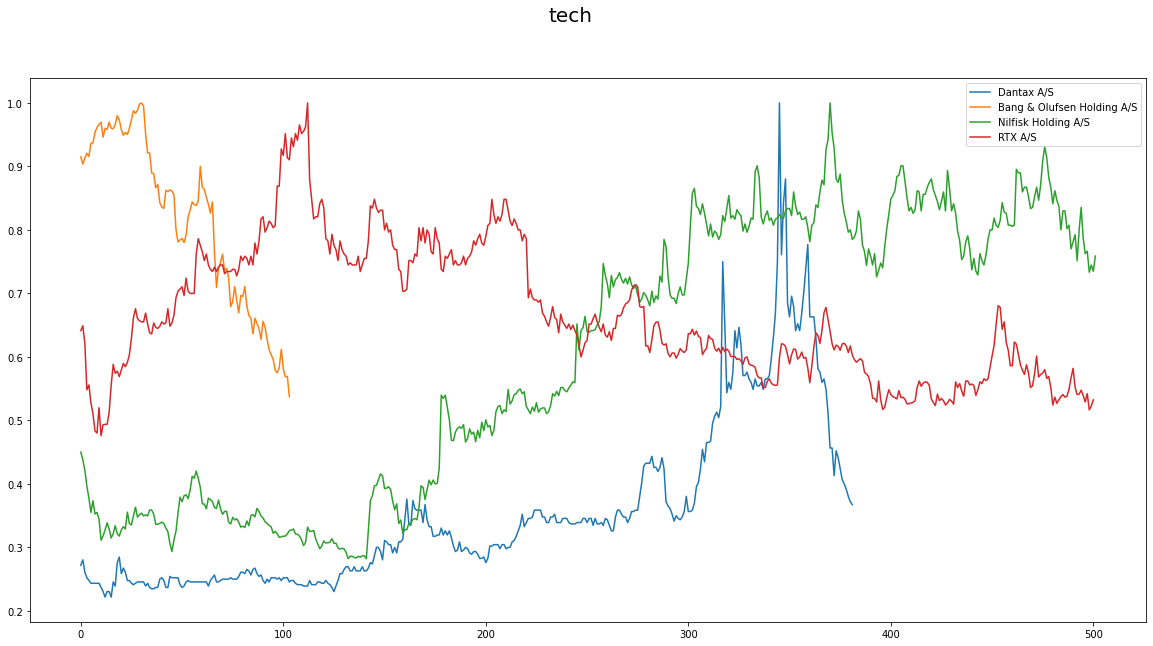

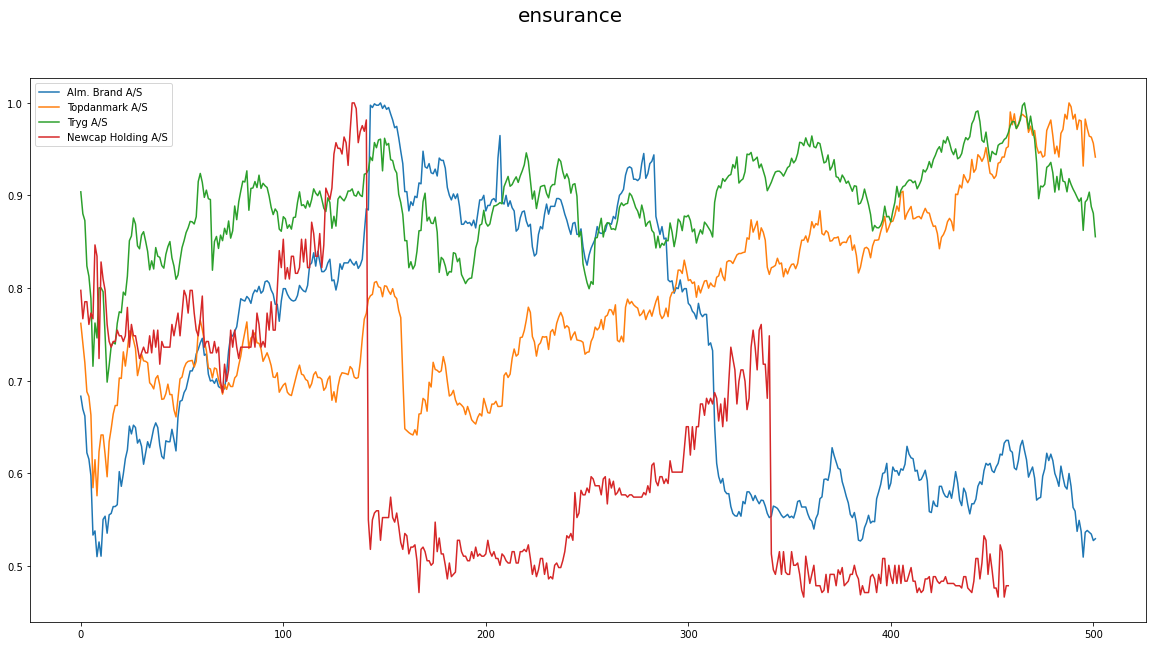

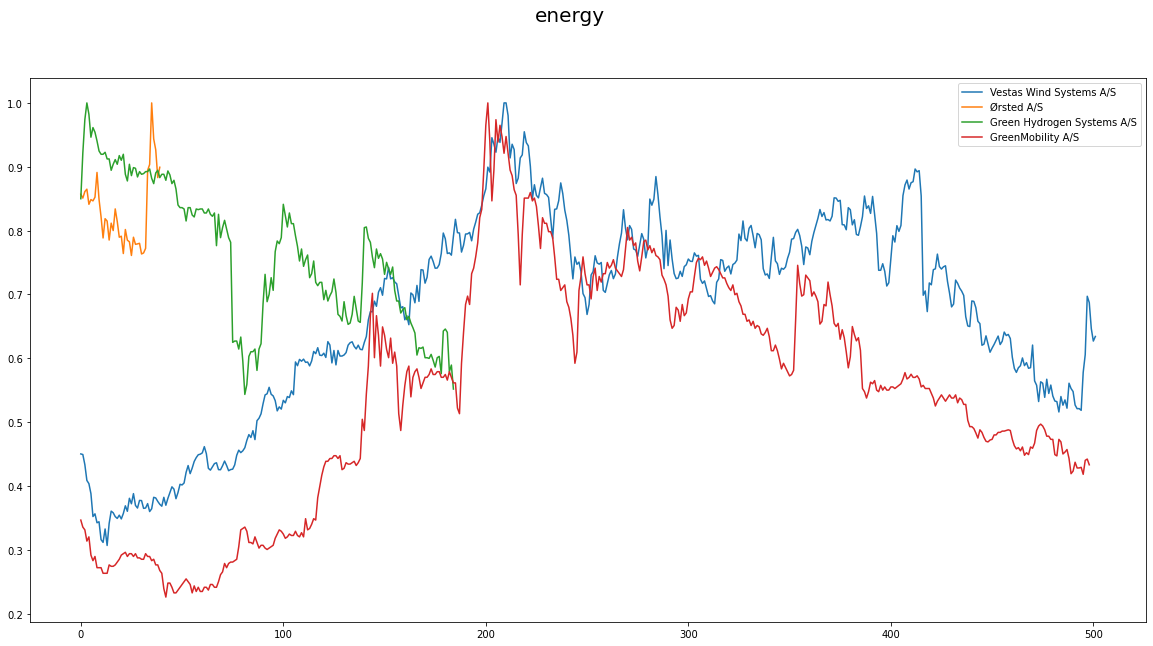

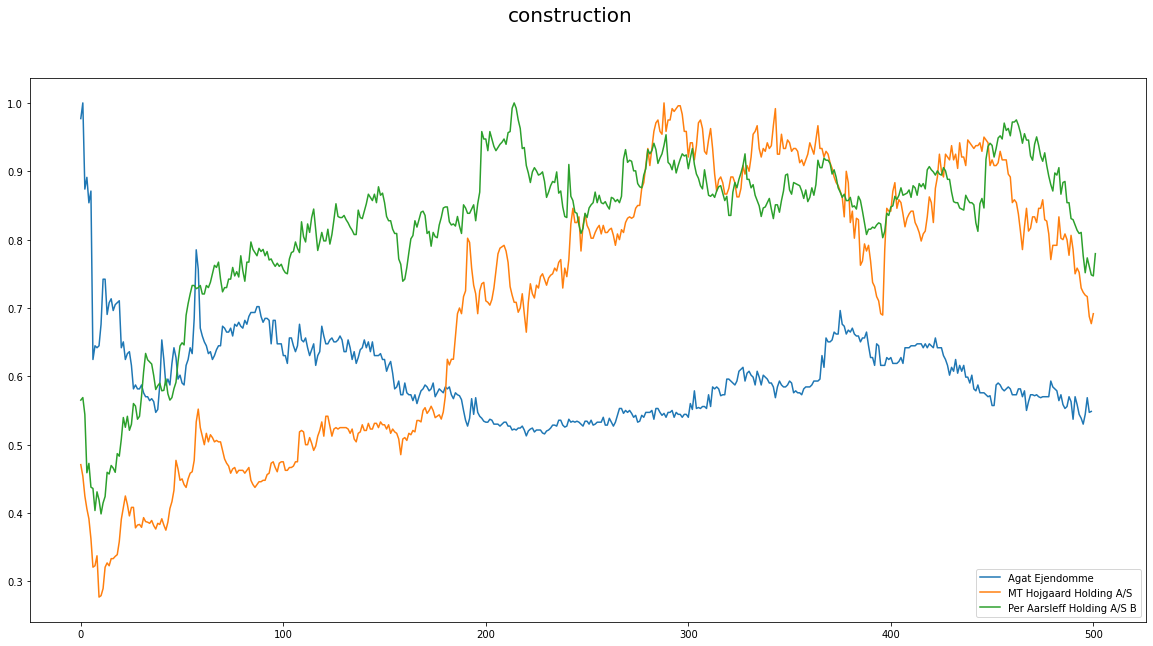

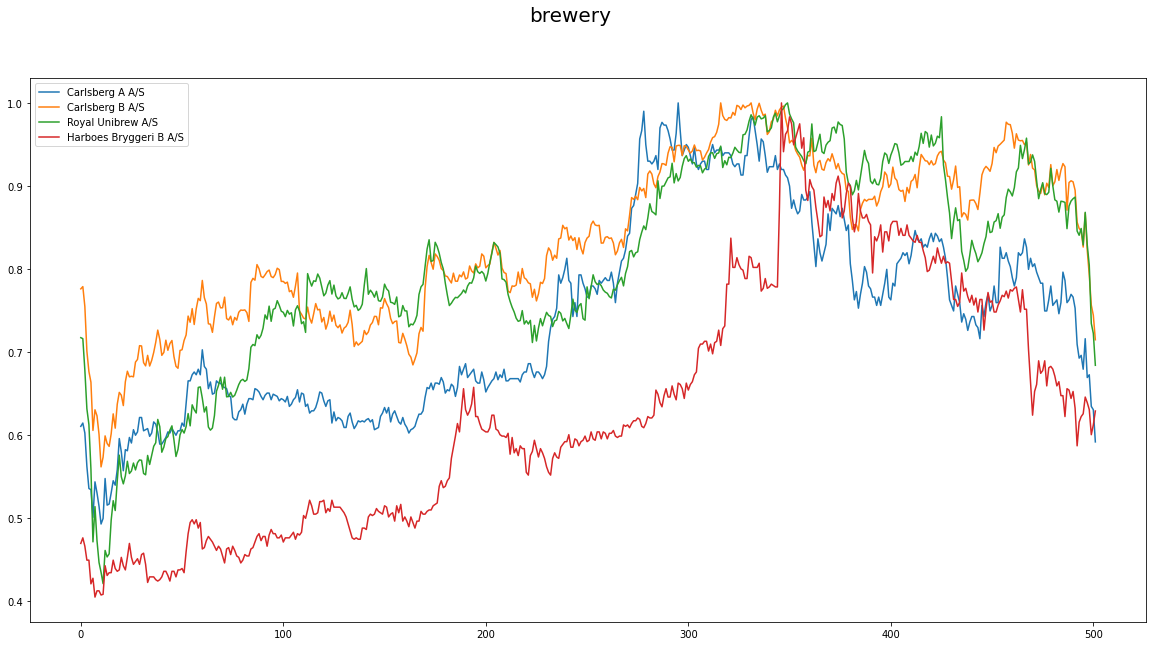

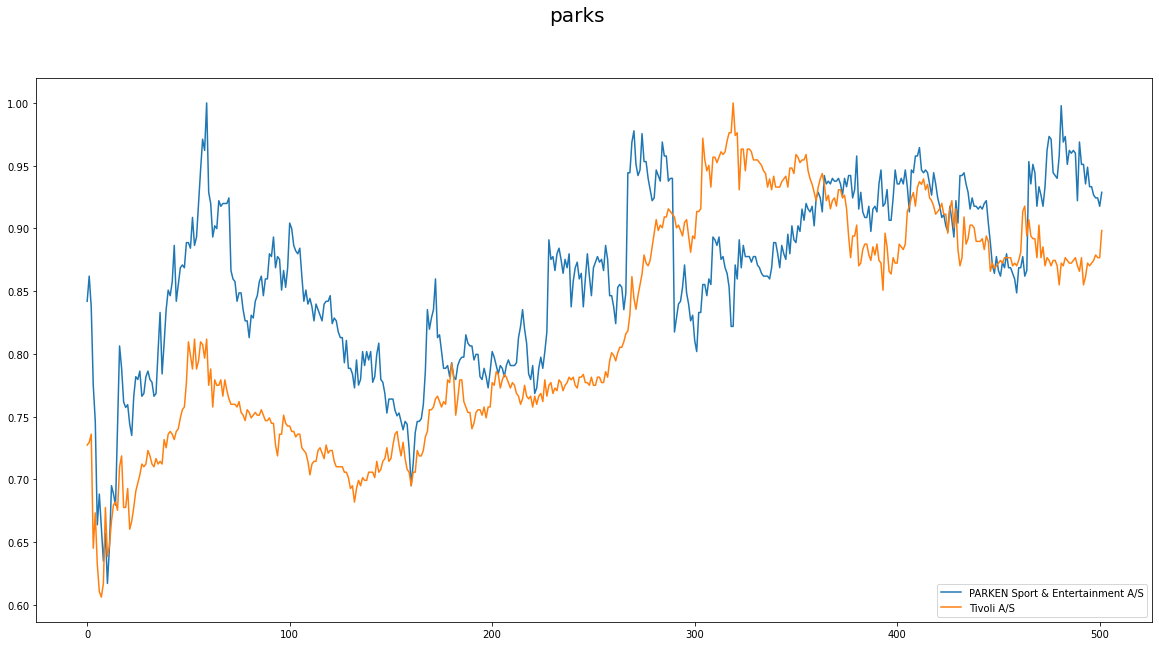

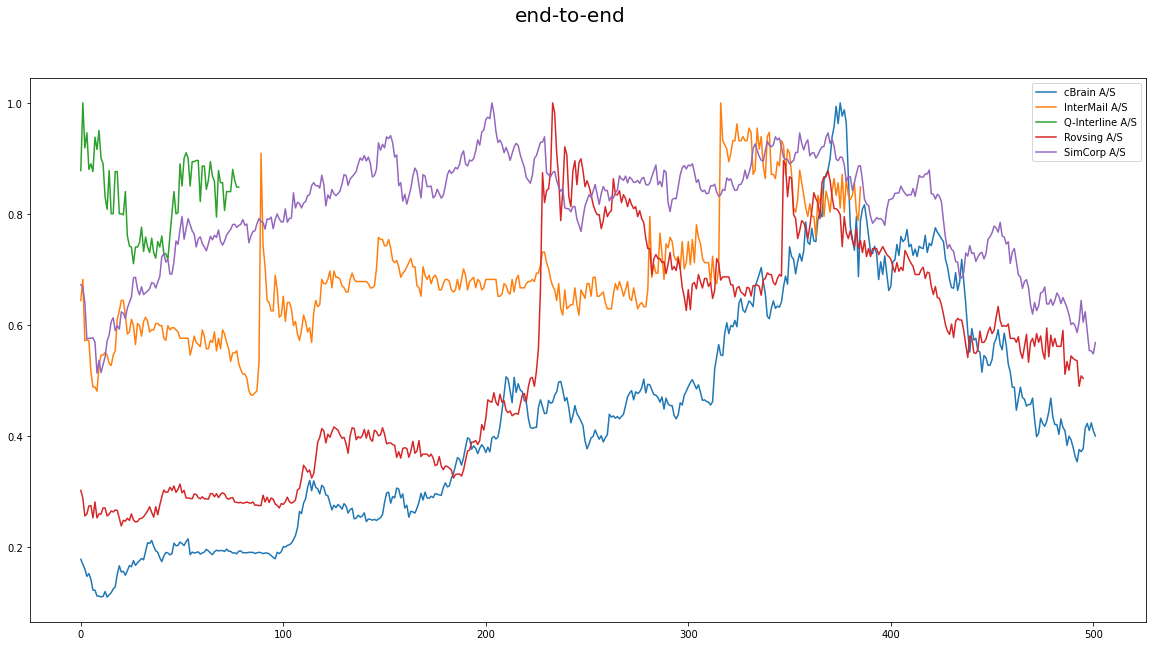

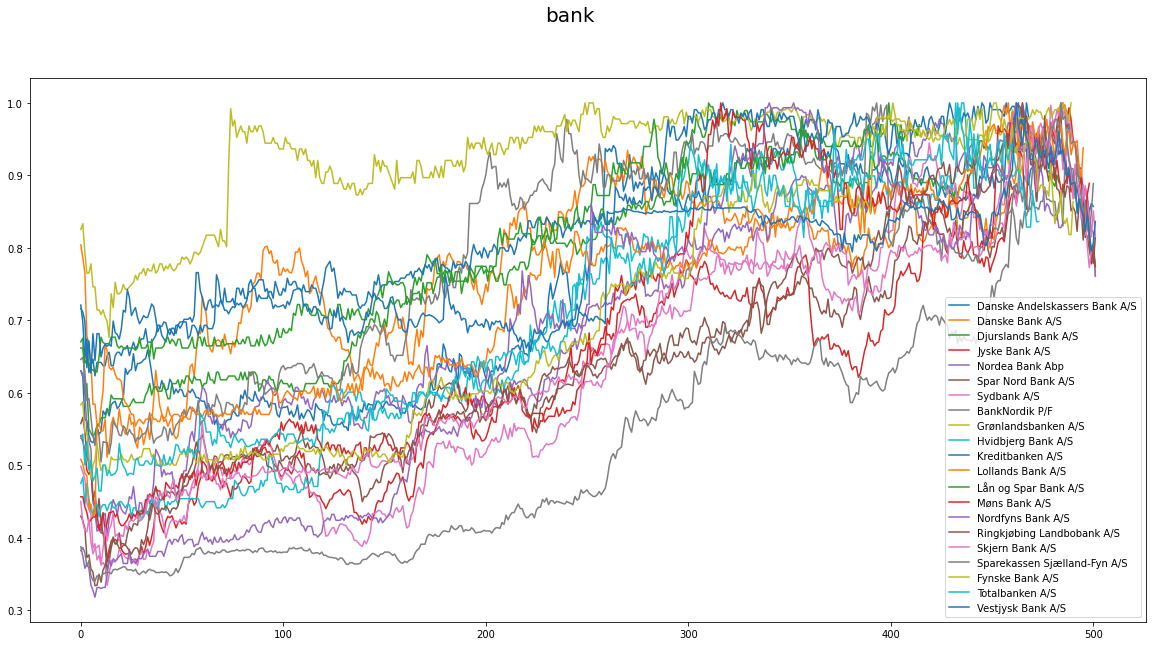

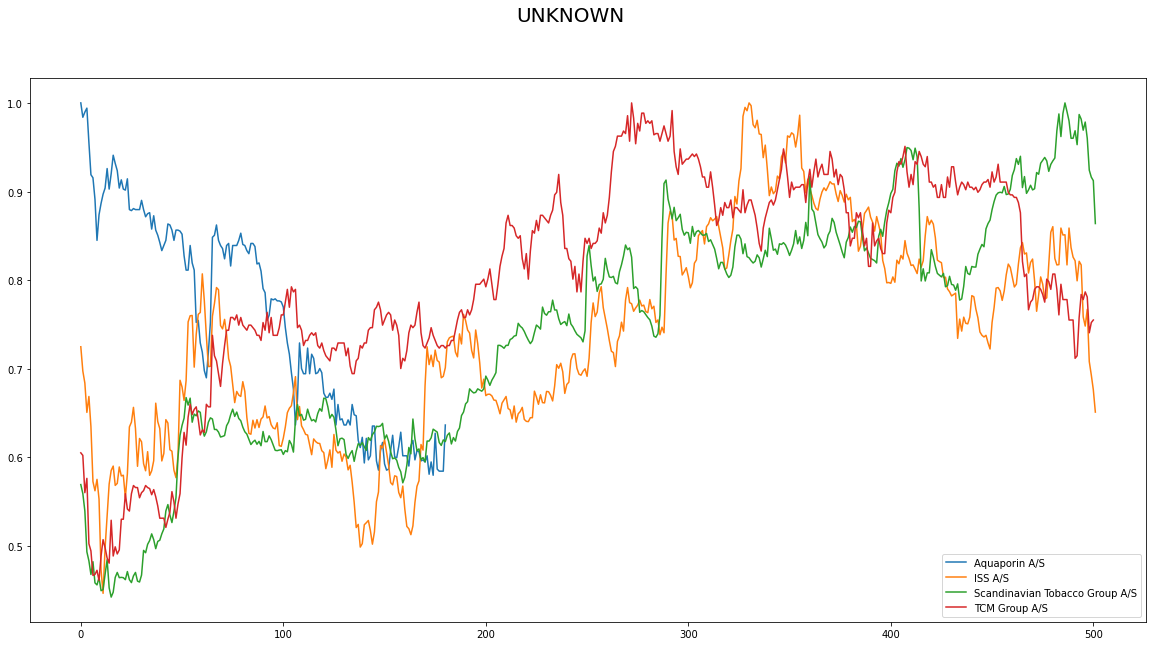

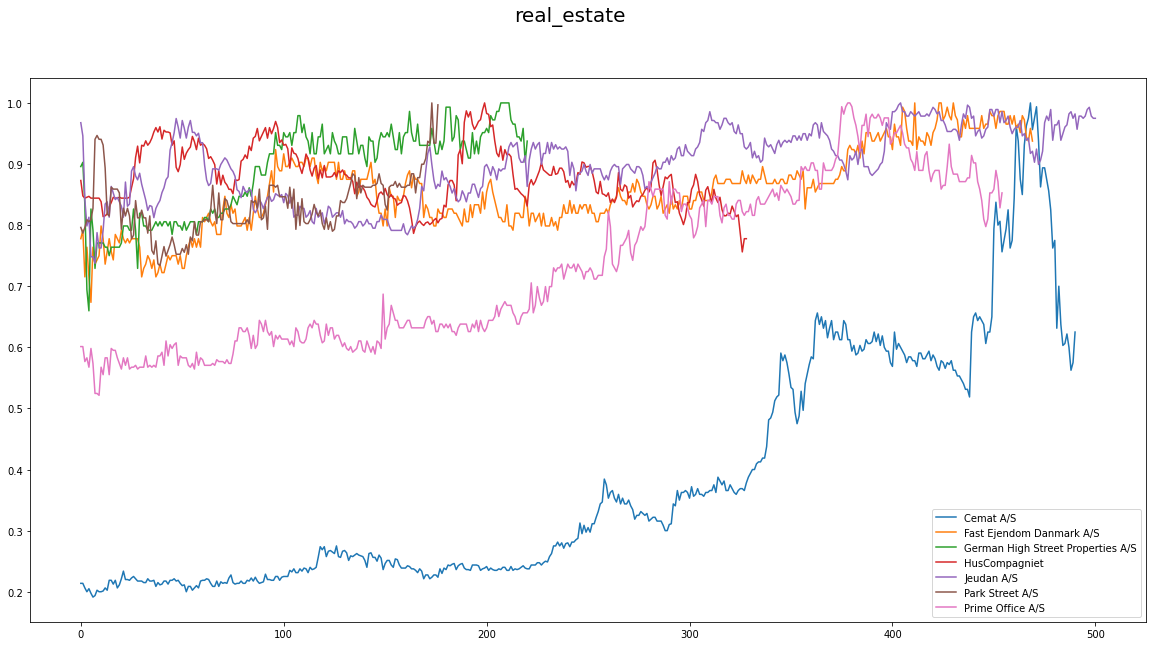

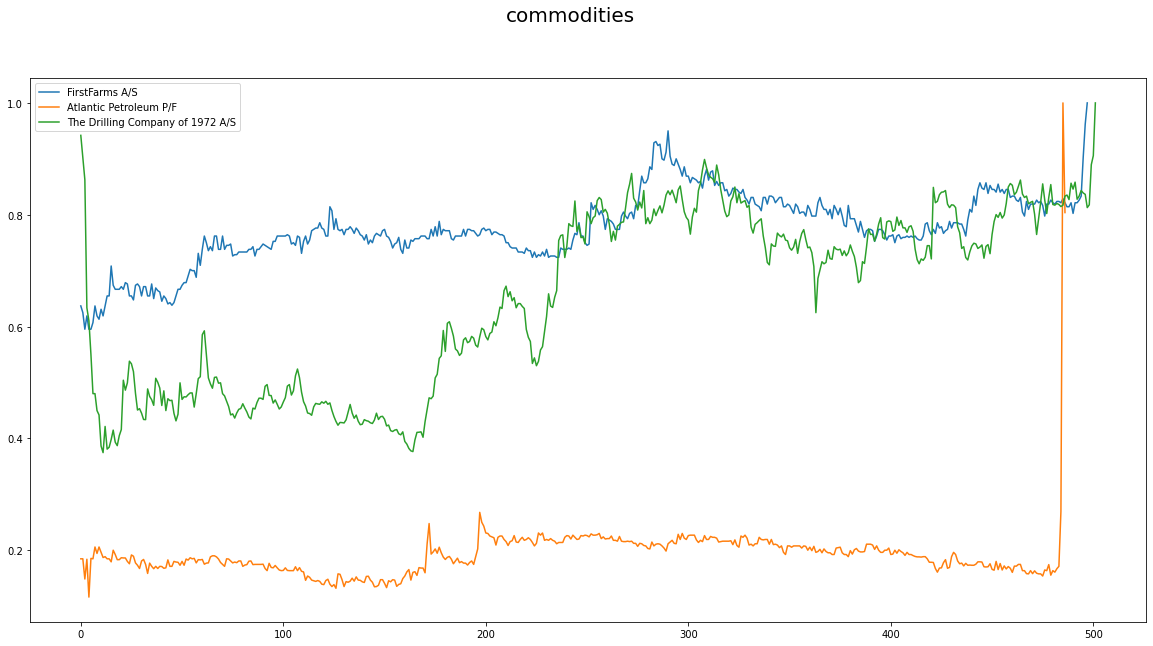

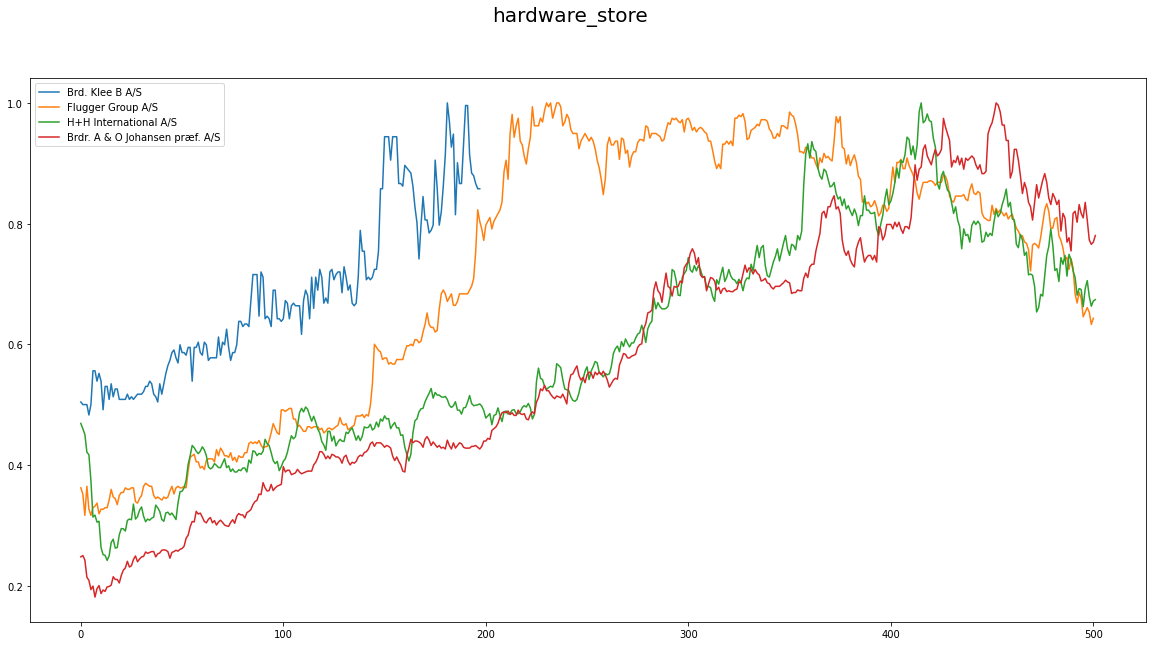

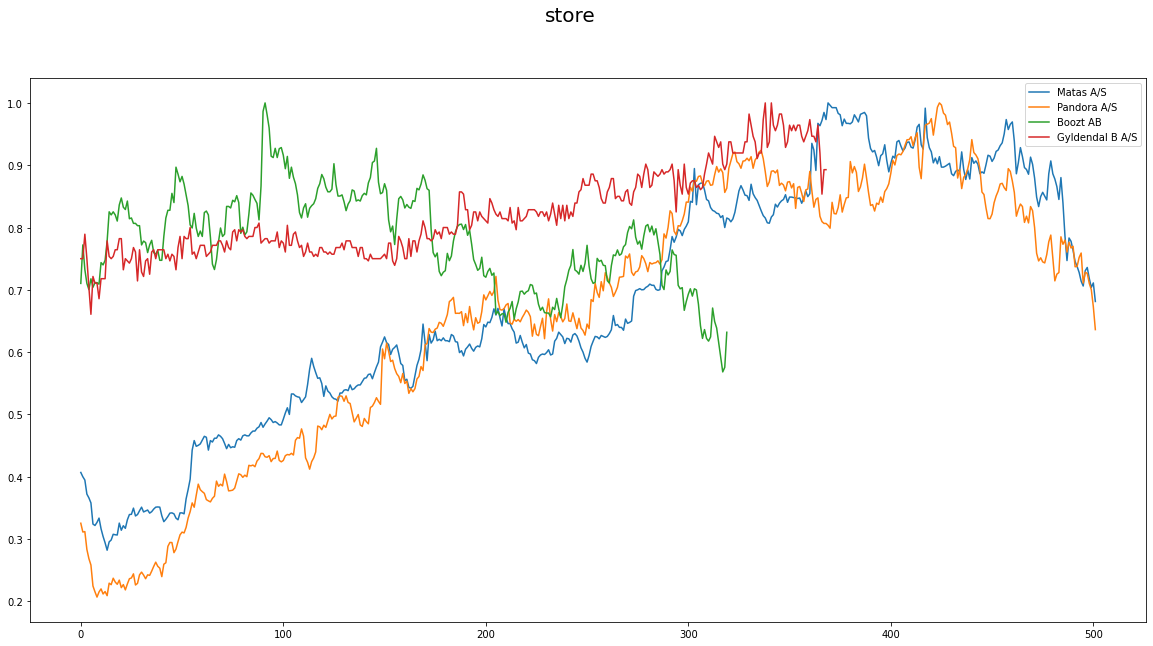

In [43]:
sub_lst = get_subcategories(conn)
for sub in sub_lst:
    indentifiers, description = get_indentifier_for_sub_category(sub, conn)
    df_lst = get_dataframes(conn, indentifiers)
    fig, ax = plt.subplots(figsize=(20,10))
    fig.suptitle(sub, fontsize=20)
    for i in range(len(df_lst)):
        df_lst[i]["close"].plot(ax=ax, label=description[i])
    ax.legend()
    plt.show()


In [ ]:
# def plot_and_save(sub_lst):
#     for sub in sub_lst:
#         indentifiers, description = get_indentifier_for_sub_category(sub, conn)
#         df_lst = get_dataframes(conn, indentifiers)
#         cols = int(len(df_lst)/2)
#         fig, axs = plt.subplots(2, cols, figsize=(20, 20), sharex=True)
#         fig.suptitle(sub, fontsize=40)
#         for i in range(len(df_lst)):
#             df_lst[i].plot(x="date", y="close", ax=axs[i//4, i%cols], title=description[i])
#         plt.savefig("figures/{}.png".format(sub))
#         # for i in range(4):
#         #     for j in range(4):
#         #         axs[i, j].plot(df_lst[i*4+j]["date"], df_lst[i*4+j]["close"])
#         #         axs[i, j].set_title(description[i*4+j])
#         #         # axs[i, j].set_xlabel("date")
#         #         axs[i, j].set_ylabel("close", rotation=90, labelpad=2)
#         #         axs[i,j].set_xticklabels(df_lst[i*4+j]["date"], rotation=15, ha="right", fontsize=10)
#         #         axs[i,j].set_yticklabels(df_lst[i*4+j]["close"], fontsize=9, fontname="Arial", fontweight="light", color="black")
#         #         plt.savefig("figures/{}.png".format(sub))

# sub_lst = get_subcategories(conn)
# plot_and_save(sub_lst)

# for each subcategory, plot the data for the last 2 years in a grid and save it as a png file
